<a href="https://colab.research.google.com/github/Axazuki/Converting-bw-images-to-color/blob/main/AI_%D0%BF%D1%80%D0%BE%D0%B5%D0%BA%D1%82_%22%D0%A7%D0%91_%D0%B2_%D1%86%D0%B2%D0%B5%D1%82%22_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подключаем необходимые библиотеки


In [ ]:
!pip install tensorflow==2.8
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

In [ ]:
import os # для работы с файлами
import cv2 # для нарезки видео
import numpy as np # для работы с массивами
from matplotlib import pyplot as plt # для визуализации изображений
%matplotlib inline 
from keras.models import Sequential # импортируем последовательную модель из керас
from keras.layers import Conv2D, UpSampling2D # импортируем необходимые слои для свёрточной сети
from skimage.color import rgb2lab # для обработки изображений
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
# подключаем гугл-диск
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Загружаем видео, готовим из него датасет

In [ ]:
path_capture = '/content/drive/MyDrive/УИИ/Мой диплом УИИ/v2.0/Дикая природа  России   Wildlife in Russia   National Geographic 4K Ultra HD.mp4'  # путь к видео
path_frame = '/content/drive/MyDrive/УИИ/Мой диплом УИИ/v2.0/frames 2/'  # директория, куда будем "нарезать" видео.
cap = cv2.VideoCapture(path_capture)  # захватываем видео
current_frame = 1  # счётчик кадров
while(True):
    try:
        _, frame = cap.read()  # читаем кадр
        if current_frame % 15 == 0:
          name = path_frame + str(current_frame) + '.jpg'  # даём ему имя
          print ('Creating ' + name)  #  Принтим.
          cv2.imwrite(name, frame)  # Создаём кадр.
        current_frame += 1  # переходим к следующему кадру
    except:
        print('Конец работы')
        break

cap.release()  # Нужные методы окончания.
cv2.destroyAllWindows()   

In [ ]:
len(os.listdir('/content/drive/MyDrive/УИИ/Мой диплом УИИ/v2.0/frames 2'))

5205

# Создаём x_train

In [ ]:
path_frame = '/content/drive/MyDrive/УИИ/Мой диплом УИИ/v2.0/frames 2/' # путь к изображениям
img_data = [] # пустой список под массивы изображений
for i in sorted(os.listdir(path_frame)): # проходим по всем изображениям в указанной папке
    img = np.array(load_img(path_frame+i, target_size=(128,128))) # подгружаем каждое изображение размером 128*128, переводим в np-массив
    img_data.append(img) # добавляем массив в список img
    print('Файл '+i+' обработан') # принтим
x_train = np.array(img_data)/255 # нормируем данные
np.save('/content/drive/MyDrive/УИИ/Мой диплом УИИ/v2.0/x_train', x_train) # сохраняем получившийся массив в файл x_train

In [ ]:
x_train = np.load('/content/drive/MyDrive/УИИ/Мой диплом УИИ/v2.0/x_train.npy') # загружаем x_train 

In [ ]:
x_train1 = rgb2lab(x_train)[:,:,:,0] # берём только lightness 
np.save('/content/drive/MyDrive/УИИ/Мой диплом УИИ/v2.0/x_train1', x_train1)

In [ ]:
y_train = rgb2lab(x_train)[:,:,:,1:]/128 # берём оставшиеся показатели a, b
np.save('/content/drive/MyDrive/УИИ/Мой диплом УИИ/v2.0/y_train', y_train)

In [ ]:
x_train1 = np.load('/content/drive/MyDrive/УИИ/Мой диплом УИИ/v2.0/x_train1.npy')
y_train = np.load('/content/drive/MyDrive/УИИ/Мой диплом УИИ/v2.0/y_train.npy')

# Архитектура НС

In [ ]:
model_CNN = Sequential()

# #Input Layer
model_CNN.add(Conv2D(8, (3, 3), input_shape=(128,128,1), activation='relu', padding='same'))

#Hidden Layers
model_CNN.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
model_CNN.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model_CNN.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
model_CNN.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model_CNN.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model_CNN.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_CNN.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_CNN.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model_CNN.add(UpSampling2D((2, 2)))
model_CNN.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model_CNN.add(UpSampling2D((2, 2)))  # scaling and resizing 
model_CNN.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model_CNN.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model_CNN.add(UpSampling2D((2, 2)))
model_CNN.compile(optimizer='rmsprop', loss='mse', metrics = ['accuracy'])

model_CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 8)       80        
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 8)         584       
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 16)        1168      
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        1

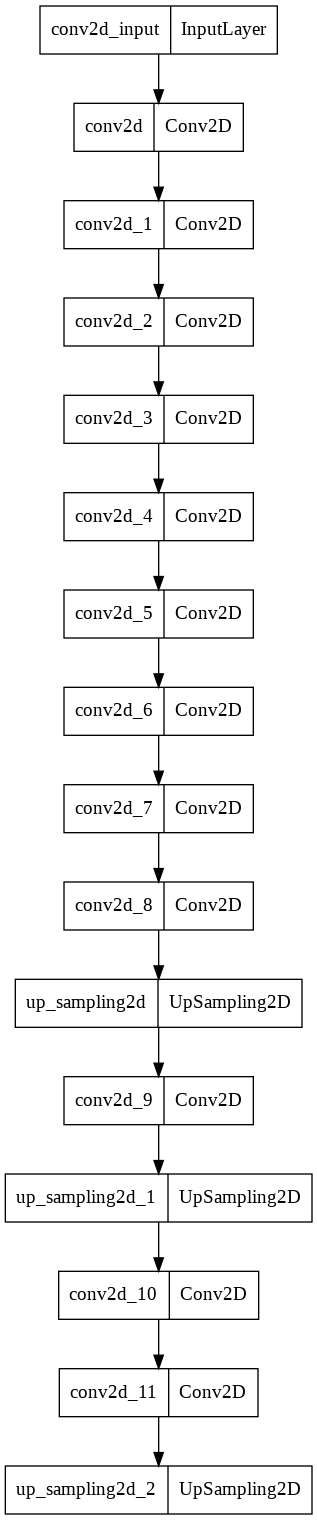

In [ ]:
plot_model(model_CNN)

# Обучение НС

In [ ]:
model_CNN.load_weights('/content/drive/MyDrive/УИИ/Мой диплом УИИ/model_weight.h5')

Epoch 1/80
163/163 [==============================] - 14s 23ms/step - loss: 0.0063 - accuracy: 0.6601
Epoch 2/80
163/163 [==============================] - 3s 21ms/step - loss: 0.0052 - accuracy: 0.7236
Epoch 3/80
163/163 [==============================] - 3s 21ms/step - loss: 0.0048 - accuracy: 0.7368
Epoch 4/80
163/163 [==============================] - 3s 21ms/step - loss: 0.0045 - accuracy: 0.7496
Epoch 5/80
163/163 [==============================] - 4s 22ms/step - loss: 0.0042 - accuracy: 0.7559
Epoch 6/80
163/163 [==============================] - 4s 23ms/step - loss: 0.0041 - accuracy: 0.7617
Epoch 7/80
163/163 [==============================] - 3s 21ms/step - loss: 0.0039 - accuracy: 0.7660
Epoch 8/80
163/163 [==============================] - 3s 21ms/step - loss: 0.0037 - accuracy: 0.7691
Epoch 9/80
163/163 [==============================] - 4s 24ms/step - loss: 0.0036 - accuracy: 0.7754
Epoch 10/80
163/163 [==============================] - 3s 21ms/step - loss: 0.0035 - accur

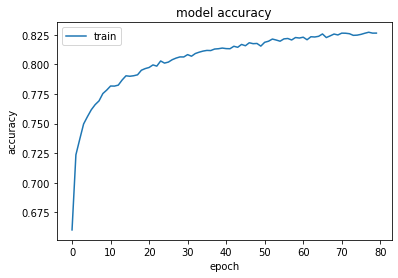

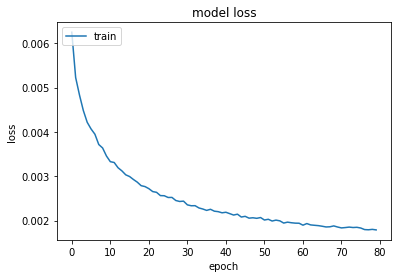

In [ ]:
trainedmodel_CNN = model_CNN.fit(x_train1, y_train, epochs=80)

plt.plot(trainedmodel_CNN.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(trainedmodel_CNN.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model_CNN.save_weights('/content/drive/MyDrive/УИИ/Мой диплом УИИ/v2.0/model_weight.h5')

# Проверка

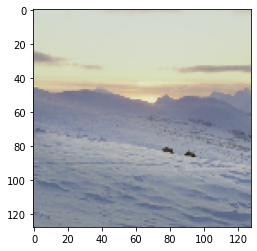

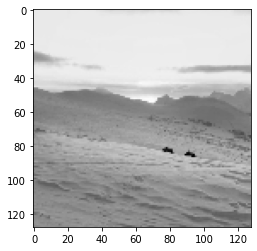

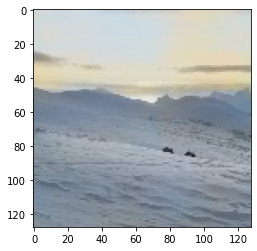

In [ ]:
path_frame = '/content/drive/MyDrive/УИИ/Мой диплом УИИ/v2.0/frames 2/'
i = os.listdir(path_frame)[4129] # берём изображения из тех, что НС не видела
img = np.array(load_img(path_frame+i, target_size=(128,128)))
img_lab = rgb2lab(img)[...,0]
img_lab1 = img_lab[None,...,None]
predict_test = model_CNN.predict(img_lab1)  # Предиктим ab формат. Размер (1,128,128,2) 
predict_test = predict_test * 128  # Отнормируем изображение. Размер (1,128,128,2)
pred_lab = np.concatenate([img_lab1,predict_test], axis=-1)  # Объединяем l и ab части в lab формат. Размер (1,128,128,3)
pred_lab = pred_lab[0]  # Берём первый элемент из формата. Размер (255,255,3).
pred_rgb = (lab2rgb(pred_lab))  # Превращаем в rgb формат. Размер (255,255,3).
plt.imshow(img) # Отображаем оригинал.
plt.show()
plt.imshow(img_lab, cmap='gray')  # Отображаем канал оттенков черного формата lab
plt.show()
plt.imshow(pred_rgb)  # Отображаем предсказанное изображения.
plt.show()

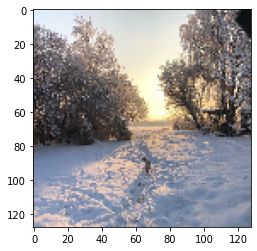

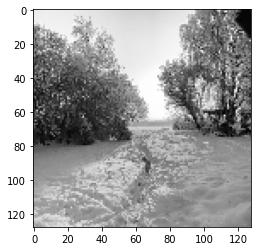

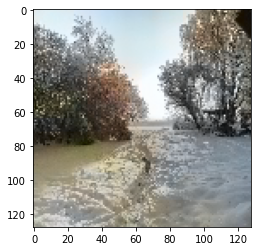

In [ ]:
# так же берём рандомную картинку из интернета
img = np.array(load_img('/content/drive/MyDrive/УИИ/Мой диплом УИИ/v2.0/1576762579113816048.jpg', target_size=(128,128)))
img_lab = rgb2lab(img)[...,0]
img_lab1 = img_lab[None,...,None]
predict_test = model_CNN.predict(img_lab1)  # Предиктим ab формат. Размер (1,128,128,52) 
predict_test = predict_test * 128  # Отнормируем изображение. Размер (1,128,128,2)
pred_lab = np.concatenate([img_lab1,predict_test], axis=-1)  # Объединяем l и ab части в lab формат. Размер (1,128,128,3)
pred_lab = pred_lab[0]  # Берём первый элемент из формата. Размер (255,255,3).
pred_rgb = (lab2rgb(pred_lab))  # Превращаем в rgb формат. Размер (255,255,3).
plt.imshow(img) # Отображаем оригинал.
plt.show()
plt.imshow(img_lab, cmap='gray')  # Отображаем канал оттенков черного формата lab
plt.show()
plt.imshow(pred_rgb)  # Отображаем предсказанное изображения.
plt.show()